# NSSP project 1
### preprocessing and GLM analysis

In this notebook, we aims to study the neural processing of emotionally provocative auditory stimuli.

# Setup the notebook

### Import, setup FSL

In [42]:
%gui wx
import sys
import os
import os.path as op

#utility functions from previous labs
import utils 

#to download the dataset from openneuro
import subprocess
import openneuro

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt

from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

#concatenation
import mne_nirs
import nilearn
from nilearn.image import concat_imgs, mean_img
import nibabel as nib

import ants

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

import matplotlib.pyplot as plt

#GLM
import nibabel as nib
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map,plot_design_matrix,plot_contrast_matrix
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

In [2]:
####################
# Setup FSL path
####################
utils.loadFSL()
################
# Start FSLeyes 
################
fsleyesDisplay = utils.FSLeyesServer()
fsleyesDisplay.show()

15:28:11: Debug: Adding duplicate image handler for 'Windows bitmap file'
15:28:11: Debug: Adding duplicate animation handler for '1' type
15:28:11: Debug: Adding duplicate animation handler for '2' type
15:28:11: Debug: Adding duplicate image handler for 'Windows bitmap file'
15:28:11: Debug: Adding duplicate animation handler for '1' type
15:28:11: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:429): Gtk-CRITICAL **: 15:28:11.950: gtk_window_resize: assertion 'height > 0' failed


In [3]:
#We define the parameters RERUN to rerun all the transform, if false it will use the saved files.
RERUN = False

### Download and explore the dataset

In [6]:
#download the dataset

#"https://openneuro.org/datasets/ds000171/versions/00001"
dataset= 'ds000171'
version = '00001'
subject = 'sub-control01'
subjectID = 'control01'

#path to save
sample_path = "dataset"
utils.mkdir_no_exist(sample_path)

# Construct paths
bids_root = os.path.join(os.path.abspath(""), sample_path, dataset)
deriv_root = os.path.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

#folder for derivative and preprocess
utils.mkdir_no_exist(deriv_root)
utils.mkdir_no_exist(preproc_root)
utils.mkdir_no_exist(op.join(preproc_root, subject))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'anat'))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'func'))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'fmap'))

#run this line only if you dont have the dataset 
if RERUN :
    subprocess.run(["openneuro-py", "download", "--dataset", dataset, "--target_dir", bids_root,"--include",subject], check=True)

Usage: openneuro-py download [OPTIONS]
Try 'openneuro-py download --help' for help.
╭─ Error ──────────────────────────────────────────────────────────────────────╮
│ No such option: --target_dir Did you mean --target-dir?                      │
╰──────────────────────────────────────────────────────────────────────────────╯


CalledProcessError: Command '['openneuro-py', 'download', '--dataset', 'ds000171', '--target_dir', '/data/dataset/ds000171', '--include', 'sub-control01']' returned non-zero exit status 2.

In [7]:
# explore the dataset folder
print_dir_tree(bids_root,5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mask_handmodif.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_all_task_bold.nii
|--------------- sub-control01_all_task_bold_bbr.mat
|--------------- sub-control01_all_task_bold_bbr.nii.gz
|--------------- sub

In [8]:
data_description = utils.get_json_from_file(op.join(bids_root,'dataset_description.json'))
data_description

data_task = utils.get_json_from_file(op.join(bids_root,'task-music_bold.json'))
data_task

{'TaskName': 'Music',
 'RepetitionTime': 3.0,
 'EchoTime': 0.025,
 'FlipAngle': 90.0,
 'SequenceName': 'EPI BOLD',
 'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'Skyra',
 'MagneticFieldStrength': 3.0,
 'ParallelImagingReductionFactor': 0,
 'SliceTimingComputationMethod': '(slicenum*RepetitionTime/TotalSlices), interleaved according to Siemens even-numbered slice convention (even slices first).',
 'SliceTiming': [1.5,
  0.0,
  1.56,
  0.06,
  1.62,
  0.12,
  1.68,
  0.18,
  1.74,
  0.24,
  1.8,
  0.3,
  1.86,
  0.36,
  1.92,
  0.42,
  1.98,
  0.48,
  2.04,
  0.54,
  2.1,
  0.6,
  2.16,
  0.66,
  2.22,
  0.72,
  2.28,
  0.78,
  2.34,
  0.84,
  2.4,
  0.9,
  2.46,
  0.96,
  2.52,
  1.02,
  2.58,
  1.08,
  2.64,
  1.14,
  2.7,
  1.2,
  2.76,
  1.26,
  2.82,
  1.32,
  2.88,
  1.38,
  2.94,
  1.44]}

In [9]:
# explore anatomical
# fsleyesDisplay.resetOverlays()
# fsleyesDisplay.load(op.join(bids_root, subject,'anat','sub-control01_T1w.nii.gz'))

# explore one functional 
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(op.join(bids_root, subject,'func','sub-control01_task-music_run-1_bold.nii.gz'))

# Pre-processing

Prior to analysis we need to pre process the data.
We will standardize each run of interest of sub-control01 and concatenate all together.<br/>
Then,we will apply standard preprocessing steps.

<b>Anatomical preprocessing</b>
1. Skull stripping
2. segmentation
3. Coregistration & Normalisation

<b>functional preprocessing</b>
1. standardisation
2. concatenation
3. motion correction
4. Coregistration & normalisation
5. smoothing

## Anatomical preprocessing

### 1.1 Skull stripping

In [10]:
#Skull stripping 
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mask'.format(subjectID))

if RERUN :
    get_skull_stripped_anatomical(bids_root, preproc_root, subjectID,robust=True)

Done with BET.


In [11]:
#display the mask and observe that the skull is correctely removed
#fsleyesDisplay.load(resulting_mask_path)

After verification and manual corrections, we consider the skull tripping mask good enough. We apply the mask.
Attention : if not handmodified, do


In [12]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    """
    Apply a mask
    """
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w'.format(subjectID)) # The original brain
betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subjectID)) # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mask_handmodif'.format(subjectID)) # The mask to use
#resulting_mask_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mask'.format(subjectID))

if RERUN :
    apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [13]:
#display the brain without the skull
#fsleyesDisplay.load(betted_brain_path)

### 1.2 Tissue Segmentation

In [14]:
#segmentation
segmentation_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_fast'.format(subjectID))

if RERUN : 
    [os.remove(f) for f in glob.glob(op.join(preproc_root, subject, 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
    fast(imgs=[betted_brain_path], out=segmentation_path, n_classes=3)

In [15]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mask_handmodif.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_all_task_bold.nii
|--------------- sub-control01_all_task_bold_bbr.mat
|--------------- sub-control01_all_task_bold_bbr.nii.gz
|--------------- sub

In [16]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(betted_brain_path)
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_0*'))[0])
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_1*'))[0])
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_2*'))[0])
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

The segmentation correctely separated grey matter, white matter and cerebrospinal fluid.

### 1.3 Anatomical normalization

In [18]:
#Coregistration

mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = betted_brain_path
reference = mni_template

#FLIRT Linear
result = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mni'.format(subjectID))
if RERUN :
    flirt(target, reference, out=result)

#FNIRT non-linear
resultAnts = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subjectID))
if RERUN :
    moving_image = ants.image_read(target + '.nii.gz')
    fixed_image = ants.image_read(reference + '.nii.gz')

    transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = 'SyN' )
    warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
    ants.image_write(warpedImage, resultAnts)


Final result: 
0.003263 0.005586 -1.115142 204.728079 
-0.932711 0.501905 0.006405 178.470887 
0.502483 1.049173 -0.003890 -149.891913 
0.000000 0.000000 0.000000 1.000000 



In [19]:
#display the coregistred brain
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(reference)
#fsleyesDisplay.load(result)
#fsleyesDisplay.load(resultAnts)

This step finish the anatomical preprocessing.

## functionnal preprocessing

### 1.1 Volume removal (check if necessary)

Text(0, 0.5, 'Mean voxel intensity')

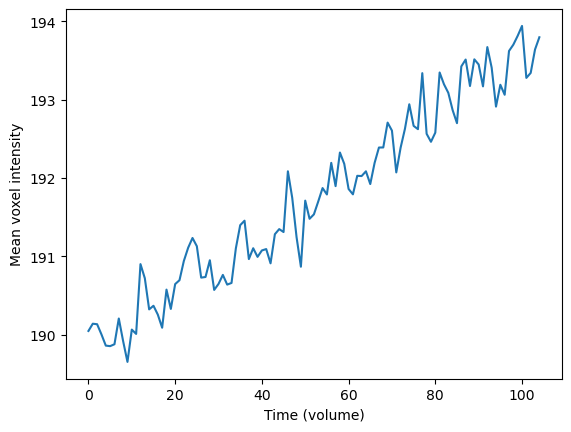

In [20]:
plt.plot(nib.load(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-music_run-1_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
#we see no need of volume removal here

### 1.2 Standardization

In [21]:
print_dir_tree(op.join(bids_root, subject, 'func')) #functionnal directory

|func/
|--- sub-control01_task-music_run-1_bold.nii.gz
|--- sub-control01_task-music_run-1_events.tsv
|--- sub-control01_task-music_run-2_bold.nii.gz
|--- sub-control01_task-music_run-2_events.tsv
|--- sub-control01_task-music_run-3_bold.nii.gz
|--- sub-control01_task-music_run-3_events.tsv
|--- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--- sub-control01_task-nonmusic_run-4_events.tsv
|--- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--- sub-control01_task-nonmusic_run-5_events.tsv
|--- .ipynb_checkpoints/
|------ sub-control01_task-music_run-2_events-checkpoint.tsv


In [22]:
import re

func_dir = op.join(bids_root, subject, 'func')
pattern = re.compile(r'^sub-control01_task-music_run-\d+_bold\.nii\.gz$')
file_paths = []

# Check if the directory exists
if os.path.exists(func_dir):
    for file_name in os.listdir(func_dir):
        # If the file name matches the pattern, add it to the array with the full path
        if pattern.match(file_name):
            full_path = os.path.join(func_dir, file_name)
            file_paths.append(full_path)
            mri = nib.load(full_path)
            print(mri.shape)


file_paths.sort()

# Output the array of all runs
print(len(file_paths))
print(file_paths)

(80, 80, 50, 105)
(80, 80, 50, 105)
(80, 80, 50, 105)
3
['/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz']


In [23]:
#fsleyesDisplay.resetOverlays()
#for file in file_paths :
#    fsleyesDisplay.load(file)

In [24]:
def standardization(input_file):
    """
    Apply z-score standardization to fMRI data

    Parameters:
    input_file (str): Path to the input
    output_file (str): Path to save the standardized output 
    """
    # Check if input file exists
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file not found: {input_file}")

    extract_name = '_'.join(os.path.basename(input_file).split('_')[1:]).rsplit('.', 2)[0]
    print(extract_name)
    output_file = os.path.join(preproc_root, subject, 'func', 'sub-{}_{}_standardize.nii'.format(subjectID,extract_name))
    
    # Load the image data
    img = nib.load(input_file)
    data = img.get_fdata()

    # Calculate global mean and standard deviation
    global_mean = data.mean()
    global_std = data.std()

    # Standardize the data (avoid division by zero)
    standardized_data = (data - global_mean) / global_std if global_std > 0 else data

    # Create a new Nifti image with the standardized data and save
    standardized_img = nib.Nifti1Image(standardized_data, img.affine, img.header)
    nib.save(standardized_img, output_file)

    return output_file
# Example usage:
stand_file_paths = []
for file in file_paths :
    stand_file_paths.append(standardization(file))

stand_file_paths

task-music_run-1_bold
task-music_run-2_bold
task-music_run-3_bold


['/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_standardize.nii',
 '/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_standardize.nii',
 '/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_standardize.nii']

### 1.3 Concatenation

In [25]:
#fsleyesDisplay.resetOverlays()
#for file in stand_file_paths :
#    fsleyesDisplay.load(file)

In [26]:
#concatenation

concat_path = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold'.format(subjectID))

if  RERUN :
    fmri_img = concat_imgs(stand_file_paths)
    nib.save(fmri_img, concat_path)

### 1.4  Motion correction

In [27]:
#motion correction

path_moco_data = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco'.format(subjectID))

if RERUN :
    mcflirt(infile=concat_path,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_all_task_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

In [28]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(concat_path)
#fsleyesDisplay.load(path_moco_data)

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002982,0.003060,-0.000131,-0.060372,-0.515789,-0.473079
1,-0.003427,0.003060,-0.000229,-0.074698,-0.494173,-0.463364
2,-0.003242,0.003177,-0.000197,-0.059108,-0.472619,-0.450286
3,-0.003235,0.003175,-0.000380,-0.074562,-0.482960,-0.463447
4,-0.002639,0.003060,-0.000313,-0.071470,-0.468797,-0.494620
...,...,...,...,...,...,...
310,0.009004,-0.000046,-0.001964,-0.087061,0.395507,0.240721
311,0.009023,-0.000047,-0.002066,-0.089177,0.372734,0.226257
312,0.009100,-0.000411,-0.002086,-0.087188,0.399878,0.224917
313,0.008964,-0.000582,-0.002106,-0.103967,0.370314,0.211559


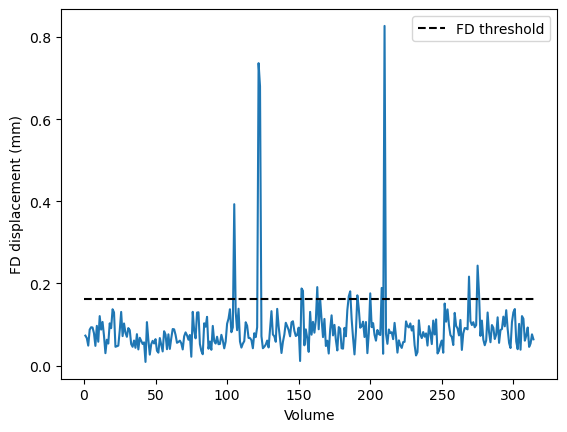

[105 122 123 152 153 163 165 185 186 191 200 208 210 269 275 276]


In [29]:
def inspect_motion_correction(path):
    """
    Function to visualise how much each volume have to be motion-corrected.
    """
    
    #extract parameters
    parameters =pd.read_csv(path, sep='  ', header=None, engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])
    display(parameters)

    #calculate frame-wise displacement
    framewise_diff = parameters.diff().iloc[1:]
    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]

    # Estimating displacement on a 50mm radius sphere
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1).to_numpy()

    #threshold
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

    #plot for each volume
    plt.plot(list(range(1, fd.size+1)), fd)
    plt.xlabel('Volume')
    plt.ylabel('FD displacement (mm)')
    plt.hlines(threshold, 0, len(parameters),colors='black', linestyles='dashed', label='FD threshold')
    plt.legend()
    plt.show()

    print(np.where(fd > threshold)[0] + 1)

path_moco_param = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco.par'.format(subjectID))
inspect_motion_correction(path_moco_param)

We have some volume with high motion. However, we have to take into account that there is 3 run in the data. From precedent analysis, we have 105 scan per run. 
We thus expect high motion around run 105 and 210 !

However, we have a big motion artefact around volume 122 and 3 small ones around volumes 152, 269 and 275. We will have to explore further.

At volume 122 there is a field map artefact.

### 1.5  Coregistration of functional to anatomical

In [30]:
subprocess.run(['fslroi'])


Usage: fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize>
       fslroi <input> <output> <tmin> <tsize>

       fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize> <tmin> <tsize>
Note: indexing (in both time and space) starts with 0 not 1! Inputting -1 for a size will set it to the full image extent for that dimension.


CompletedProcess(args=['fslroi'], returncode=1)

In [31]:
#EPI coregistration
whole_t1 = anatomical_path
skull_stripped_t1 = betted_brain_path
output_path = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_bbr'.format(subjectID))

ref_vol_name =  op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco_vol_middle'.format(subjectID))

fslroi(path_moco_data, ref_vol_name, str(157), str(1))

white_matter_segmentation = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_fast_pve_2.nii.gz'.format(subjectID)) # We provide the white matter segmentation

if RERUN :
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

FLIRT pre-alignment
Running BBR
0.286442 0.999651 -0.017010 -0.020213 0.000000 0.016821 0.999813 -0.009488 0.000000 0.020371 0.009144 0.999751 0.000000 -4.175753 4.107708 4.448656 1.000000 


In [34]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(skull_stripped_t1)
#fsleyesDisplay.load(output_path)

In [33]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

cleanup_epi_reg(op.join(preproc_root, subject, 'func'))

### 1.6  Smoothing

In [35]:
#smoothing
smoothed_path = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco_smoothed-6mm'.format(subjectID))

if RERUN:
    cmd = 'fslmaths {} -s {} {}'.format(path_moco_data, 6/2.3548, path_moco_data)
    subprocess.run(['fslmaths',path_moco_data, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(path_moco_data)])

In [36]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(smoothed_path)

# GLM analysis

### Experimental design matrix

In [37]:
#for one run
run_1 = os.path.join(bids_root, subject, 'func', 'sub-{}_task-music_run-1_events.tsv'.format(subjectID))
pd.read_csv(run_1,sep = '\t')

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [38]:
#for all runs 

func_dir = op.join(bids_root, subject, 'func')
pattern = re.compile(r'^sub-control01_task-music_run-\d+_events\.tsv$')
#pattern = re.compile(r'^sub-control01_task-music_run-2_events\.tsv$')

file_paths = []

# Check if the directory exists
if os.path.exists(func_dir):
    for file_name in os.listdir(func_dir):
        # If the file name matches the pattern, add it to the array with the full path
        if pattern.match(file_name):
            full_path = os.path.join(func_dir, file_name)
            file_paths.append(full_path)
file_paths.sort()
# Output the array of all runs
print(len(file_paths))
print(file_paths)

events = pd.DataFrame()
for file in file_paths:
    new_event = pd.read_csv(file,sep = '\t')
    if len(events) > 0 :
        last_onset = events.iloc[-1].onset
        new_event['onset'] += last_onset
    events = pd.concat([events, new_event], ignore_index=True)
events

3
['/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_events.tsv', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_events.tsv']


,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [45]:
# Specify the GLM
# according to task-music_bold.json, the TR is 3 sec
fmri_glm = FirstLevelModel(t_r=3.0,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
dpath = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco_smoothed-6mm.nii.gz'.format(subjectID))
#dpath  = '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz'
fmri_glm = fmri_glm.fit(dpath, events)

<Axes: label='conditions', ylabel='scan number'>

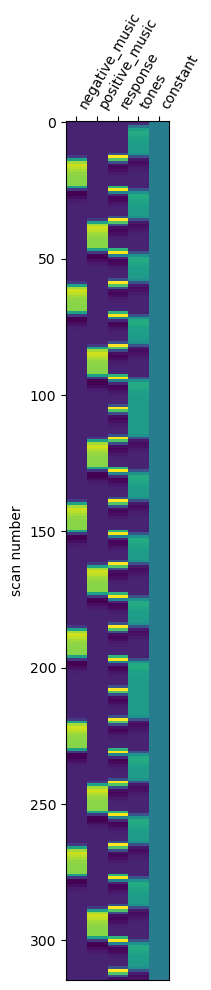

In [46]:
plot_design_matrix(fmri_glm.design_matrices_[0])

### GLM : condition and contrast

In [47]:
# Create the dictionary of the conditions

conditions = {
    'neg_music': np.array([1, 0, 0, 0, 0]), 
    'pos_music':np.array([0, 1, 0, 0, 0]),
    'response':np.array([0, 0, 1, 0, 0]),
    'tones':np.array([0, 0, 0, 1, 0]),
}

pos_neg_contrast = conditions['pos_music'] - conditions['neg_music']

<Axes: label='conditions'>

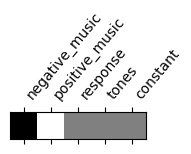

In [48]:
plot_contrast_matrix(pos_neg_contrast, design_matrix=fmri_glm.design_matrices_[0])

### Analyse GML result 

In [61]:
z_map = fmri_glm.compute_contrast(pos_neg_contrast,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

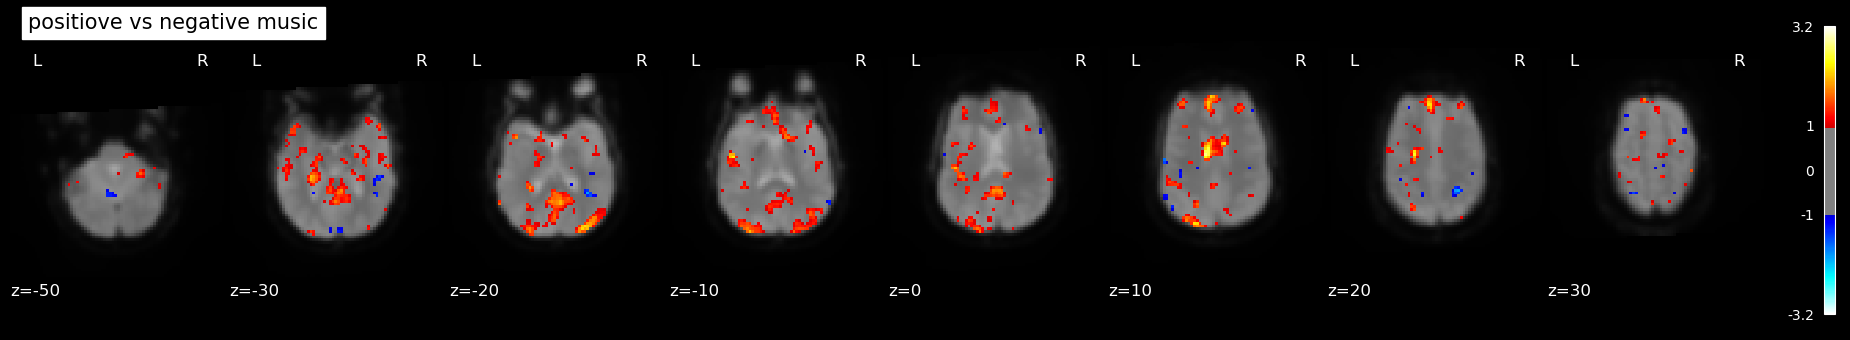

In [55]:
mean_img_ = mean_img(dpath),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=1.0,
              display_mode='z', cut_coords=[-50,-30,-20,-10,0,10,20,30], black_bg=True,
              title='positiove vs negative music')

In [ ]:
cluster_size = 1 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

print(threshold)
mean_img_ = mean_img(dpath),
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-50,-30,-20,-10,0,10,20,30], black_bg=True,
              title='positiove vs negative music (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
